In [66]:
# imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 16})

# get current working directory
cwd = os.getcwd()
%cd /Users/efz/British Airline Data Science Virtual Internship Program

file_path = "./British_Airline_Booking.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")
print(df.head())

# reset index of dataframe
df = df.reset_index(drop=True)

# store the label for supervised learning
label = df['booking_complete']

# drop the label column from the final dataframe
df_final = df.drop('booking_complete', axis=1)




[Errno 2] No such file or directory: '/Users/efz/British Airline Data Science Virtual Internship Program'
/Users/efz/Data Science Projects/British Airline
   num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
0               2            262              19            7           6   
1               1            112              20            3           6   
2               2            243              22           17           3   
3               1             96              31            4           6   
4               2             68              22           15           3   

   wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
0                    1                     0                      0   
1                    0                     0                      0   
2                    1                     1                      0   
3                    0                     0                      1   
4                    1     

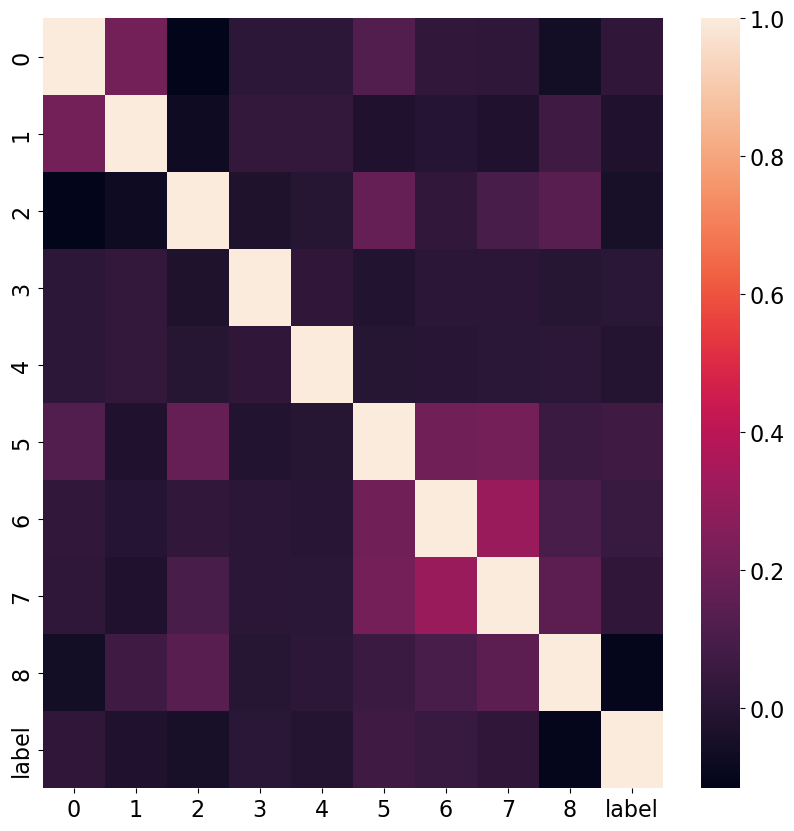

In [67]:
# encode categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
df_final_encoded = encoder.fit_transform(df_final.select_dtypes(include=['object'])).toarray()

# scale numeric variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_numeric_scaled = scaler.fit_transform(df_final.select_dtypes(include=['float64', 'int64']))

# concatenate encoded and scaled dataframes
df_final_processed = np.concatenate((df_final_numeric_scaled, df_final_encoded), axis=1)

# add the labels back to the dataframe
df_final_processed = pd.DataFrame(df_final_processed)
df_final_processed['label']  = label

# correlation matrix
corr = df_final_processed.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr)

# split data into train and test sets
from sklearn.model_selection import train_test_split
X = df_final_processed.iloc[:,:-1]
y = df_final_processed['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:

# fit and predict using XGBoost
!pip install xgboost

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score
def model_fit_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

clf_xgb = xgb.XGBClassifier(use_label_encoder=False, random_state=0, max_depth=50, learning_rate=0.05, min_child_weight=5)
y_pred_train = model_fit_predict(clf_xgb, X_train, y_train, X_train)



/Users/Software/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [69]:
# calculate metrics for training data
f1 = round(f1_score(y_train, y_pred_train), 2)
acc = round(accuracy_score(y_train, y_pred_train), 2)
pre = round(precision_score(y_train, y_pred_train), 2)
print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.89, 0.98 and 0.46 respectively


In [70]:

# check testing accuracy
y_pred_test = model_fit_predict(clf_xgb, X_train, y_train, X_test)
f1 = round(f1_score(y_test, y_pred_test), 2)
acc = round(accuracy_score(y_test, y_pred_test), 2)
pre = round(precision_score(y_test, y_pred_test), 2)
print(f"Accuracy, precision and f1-score for testing data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for testing data are 0.85, 0.38 and 0.1 respectively


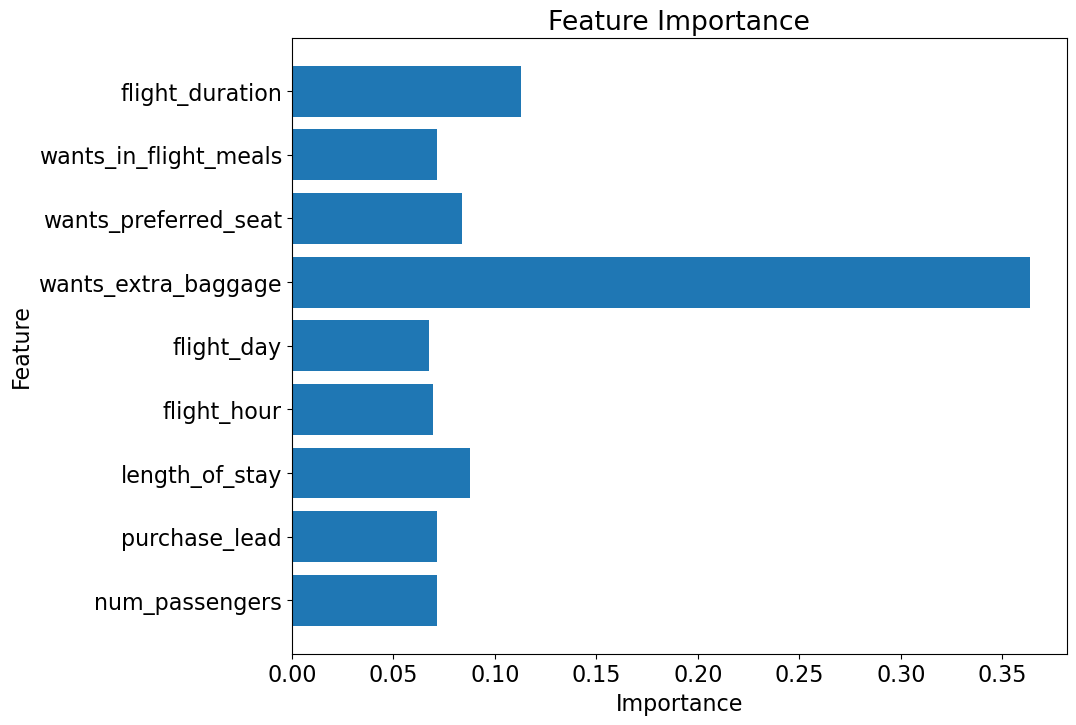

In [71]:
# Visualize feature importance
importance = clf_xgb.feature_importances_
feature_names = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']

plt.figure(figsize=(10,8))
plt.barh(feature_names, importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [72]:
print(df_final_processed)

              0         1         2         3         4         5         6  \
0      0.400684  1.957530 -0.119353 -0.381764  1.096754  0.703747 -0.649919   
1     -0.579559  0.299164 -0.089844 -1.120780  1.096754 -1.420965 -0.649919   
2      0.400684  1.747470 -0.030824  1.465775 -0.408687  0.703747  1.538654   
3     -0.579559  0.122272  0.234761 -0.936026  1.096754 -1.420965 -0.649919   
4      0.400684 -0.187290 -0.030824  1.096267 -0.408687  0.703747 -0.649919   
...         ...       ...       ...       ...       ...       ...       ...   
49995  0.400684 -0.640577 -0.502977 -0.012257  1.096754  0.703747 -0.649919   
49996 -0.579559  0.288108 -0.502977 -0.936026  1.598567 -1.420965 -0.649919   
49997 -0.579559 -0.673744 -0.502977  2.389544  1.096754 -1.420965 -0.649919   
49998 -0.579559 -0.773246 -0.502977  0.357251 -1.412314  0.703747 -0.649919   
49999 -0.579559 -0.729023 -0.502977  0.172497  0.093127 -1.420965  1.538654   

              7         8  label  
0     -0.863497 

In [73]:
# Generally XGBoost achieves better performance than random forest. and XGBoost dictates that wants_extra_baggage is the most important feature